# Create weather-dependent smartds files (at peak demand timestep)
1. Define path to opendss region folder
2. Load data - measured and predicted buildings demand
3. Convert building kw timeseries to smart-ds kw and kvar loadshapes and max values
4. Extract temp from regional peak time
5. Create smart-ds LineCodes.dss and Transformers.dss using temp
6. Create smart-ds csv profiles, Loads.dss, LoadShapes.dss using buildings demand predictions
7. Create master.dss with paths to new load.dss and loadshapes.dss + LineCodes.dss and Transformers.dss

## Initialize files

### Import packages

In [3]:
import time
import datetime
import os
import numpy as np 
import glob
import re
import shutil #To enable duplicating files
import pandas as pd # to create data frames
import joblib
import yaml
import matplotlib.pyplot as plt
import math
import gc
import sys
from collections import defaultdict

from opendssdirect import dss
from src import input_ops
from src import opendss_ops
from src import file_ops
from src import df_ops

### Load config file with scenarios and parameters 

In [4]:
config_file_name = 'opendss_config1'; config_path = f"/home/aviadf/opendss/notebooks/config/{config_file_name}.yaml"; config = input_ops.load_config(config_path)

TGW_years_scenarios = config['TGW_years_scenarios'] 

CITY_REGIONS_TO_RUN = config['CITY_REGIONS_TO_RUN']
    
demand_mode = config['demand_mode'] # 'linear_load_growth' | 'MLP'
line_rating_mode = config['line_rating_mode'] # 'heat_balance_linear_proxy' uses heat-balance eq. to find %/C linear relationship between SMART-DS default ampacity (assumed to be set for near_worst_temp, e.g., p99) and real-timetemp
transformers_rating_mode = config['transformers_rating_mode'] # 'ieee_linear_proxy' uses a linear conservative approximation from IEEE 738

aggregation_level = config['aggregation_level']

smart_ds_year = config['smart_ds_years'][0]
start_month = config['start_month']
end_month = config['end_month']
smart_ds_load_path = config['smart_ds_load_path'] + f"/{smart_ds_year}" # path to procesed smart-ds resstock data 

input_data_prediction_path = config['input_data_prediction_path']

solution_mode = config['solution_mode'] # yearly | snapshot

## Define variables to create list of mdh to run
start_month_mdh = config['start_month_mdh'] 
end_month_mdh = config['end_month_mdh']
top_percent_mdh = config['top_percent_mdh']

## Load dictionary, sort by total city aggregated buildings demand, extract mdh of top % load hours
## load demand data 
regional_demand_weather_ampacity_path = smart_ds_load_path + f"/all_cities/aggregated_demand"
regional_demand_weather_ampacity_all_cities = joblib.load(os.path.join(regional_demand_weather_ampacity_path, "regional_demand_weather_ampacity_all_cities"))
## Sort your dictionary by aggregated total demand  
regional_demand_weather_ampacity_all_cities_sorted = df_ops.sort_nested_dict_dfs(regional_demand_weather_ampacity_all_cities, "aggregated_predicted_buildings_total_kw", ascending=False)
top_n_hours = int(np.ceil(8760*top_percent_mdh/100)) # calculate top city demand hours to run (top_percent_mdh% of hours of the year)
## Define start and end load hours to run
start_row_percent = config['start_row_percent'] # define percentage of last run to avoid running same mdh again, e.g., start_row_percent = 1 means that loop will start from the 99th percentile hours
start_row_idx = int(np.ceil(8760*start_row_percent/100)) # index from which to start loop of load hours
# start_row_idx = 0 # index from which to start loop of load hours
end_row_idx = top_n_hours 

print(f"TGW_years_scenarios: {TGW_years_scenarios} \nsmart_ds_year:{smart_ds_year} \nsolution_mode:{solution_mode} \ncity region: {CITY_REGIONS_TO_RUN} \n Demand mode: {demand_mode} \nline_rating_mode: {line_rating_mode} \ntransformers_rating_mode: {transformers_rating_mode}")

print(f"\n\ntop_percent_mdh: {top_percent_mdh}%, top_n_hours: {top_n_hours}, start_row_idx:{start_row_idx} ({start_row_percent}%), end_row_idx:{end_row_idx} ({top_percent_mdh}%) \n")

TGW_years_scenarios: {'2018': ['historical'], '2058': ['rcp45cooler', 'rcp45hotter', 'rcp85cooler', 'rcp85hotter']} 
smart_ds_year:2018 
solution_mode:snapshot 
city region: {'GSO': ['rural', 'industrial', 'urban-suburban'], 'AUS': ['P1R', 'P1U', 'P2U'], 'SFO': ['P1U', 'P2U', 'P1R']} 
 Demand mode: MLP 
line_rating_mode: heat_balance_linear_proxy 
transformers_rating_mode: ieee_linear_proxy


top_percent_mdh: 20%, top_n_hours: 1752, start_row_idx:0 (0%), end_row_idx:1752 (20%) 



## Compare mdh for different climate scenario and years

In [14]:
list_of_mdh = {}
for TGW_weather_year, TGW_scenarios in TGW_years_scenarios.items():
    for TGW_scenario in TGW_scenarios:
        list_of_mdh[(TGW_weather_year, TGW_scenario)] = {}
        print(f"--- Creating list for TGW_scenario:{TGW_scenario} TGW_weather_year:{TGW_weather_year} --- \n")
        for city, regions in CITY_REGIONS_TO_RUN.items():
            ## create list of mdh for top % hours
            df_city = regional_demand_weather_ampacity_all_cities_sorted[(TGW_weather_year, TGW_scenario)][city]   # load regional demand data to later create list of mdh for top % hours  
            list_of_mdh[(TGW_weather_year, TGW_scenario)][(city)] = df_ops.get_top_n_mdh(df_city, top_n_hours, start_month_mdh, end_month_mdh)


--- Creating list for TGW_scenario:historical TGW_weather_year:2018 --- 

--- Creating list for TGW_scenario:rcp45cooler TGW_weather_year:2058 --- 

--- Creating list for TGW_scenario:rcp45hotter TGW_weather_year:2058 --- 

--- Creating list for TGW_scenario:rcp85cooler TGW_weather_year:2058 --- 

--- Creating list for TGW_scenario:rcp85hotter TGW_weather_year:2058 --- 



In [11]:
# Example: pick two lists of mdh
mdh_list_1 = list_of_mdh[('2058', 'rcp45hotter')]['GSO']
mdh_list_2 = list_of_mdh[('2058', 'rcp85hotter')]['GSO']

# Convert to sets for comparison
set1 = set(mdh_list_1)
set2 = set(mdh_list_2)

# Find intersections and differences
common = set1 & set2
only_in_1 = set1 - set2
only_in_2 = set2 - set1

# Show results side by side in a DataFrame
import pandas as pd

df_compare = pd.DataFrame({
    "Only in (2058,rcp45hotter)": sorted(list(only_in_1)),
    "Only in (2058,rcp85hotter)": sorted(list(only_in_2)),
})

print("Common MDH (present in both):")
print(sorted(list(common)))
print("\nDifferences side by side:")
print(df_compare)


Common MDH (present in both):
[(6, 1, 6), (6, 1, 7), (6, 1, 8), (6, 1, 9), (6, 1, 10), (6, 1, 11), (6, 1, 12), (6, 1, 13), (6, 1, 14), (6, 1, 15), (6, 1, 16), (6, 1, 17), (6, 1, 18), (6, 1, 19), (6, 1, 20), (6, 2, 8), (6, 2, 9), (6, 2, 10), (6, 2, 11), (6, 2, 12), (6, 2, 13), (6, 2, 14), (6, 2, 15), (6, 2, 16), (6, 2, 17), (6, 3, 8), (6, 3, 9), (6, 3, 10), (6, 3, 11), (6, 3, 12), (6, 3, 13), (6, 3, 14), (6, 3, 15), (6, 3, 16), (6, 3, 17), (6, 3, 18), (6, 3, 19), (6, 4, 6), (6, 4, 7), (6, 4, 8), (6, 4, 9), (6, 4, 10), (6, 4, 11), (6, 4, 12), (6, 4, 13), (6, 4, 14), (6, 4, 15), (6, 4, 16), (6, 4, 17), (6, 4, 18), (6, 4, 19), (6, 4, 20), (6, 5, 7), (6, 5, 8), (6, 5, 9), (6, 5, 10), (6, 5, 11), (6, 5, 12), (6, 5, 13), (6, 5, 14), (6, 5, 15), (6, 5, 16), (6, 5, 17), (6, 5, 18), (6, 5, 19), (6, 5, 20), (6, 6, 6), (6, 6, 7), (6, 6, 8), (6, 6, 9), (6, 6, 10), (6, 6, 11), (6, 6, 12), (6, 6, 13), (6, 6, 14), (6, 6, 15), (6, 6, 16), (6, 6, 17), (6, 6, 18), (6, 6, 19), (6, 6, 20), (6, 7, 7), (6, 7

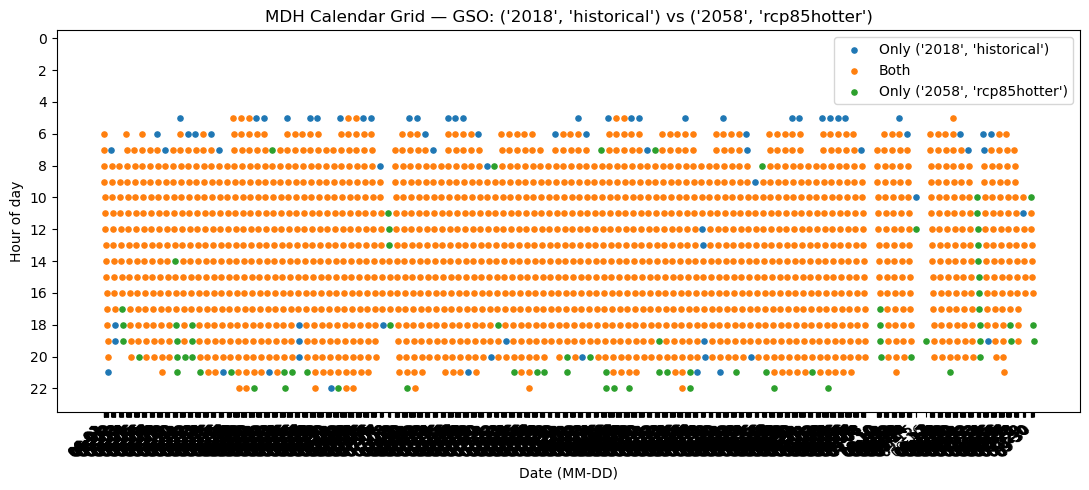

In [12]:
import pandas as pd
import matplotlib.pyplot as plt


def plot_mdh_calendar_grid(list_of_mdh, city, key1, key2, dummy_year=2000):
    mdh_list_1 = list_of_mdh[key1][city]
    mdh_list_2 = list_of_mdh[key2][city]

    set1, set2 = set(mdh_list_1), set(mdh_list_2)
    both  = sorted(set1 & set2, key=lambda t: (t[0], t[1], t[2]))
    only1 = sorted(set1 - set2, key=lambda t: (t[0], t[1], t[2]))
    only2 = sorted(set2 - set1, key=lambda t: (t[0], t[1], t[2]))

    def to_dt(triple):
        m, d, h = triple
        return pd.Timestamp(dummy_year, m, d, h)

    # Prepare x (datetime) and y (hour)
    x1 = [to_dt(t) for t in only1]
    y1 = [ts.hour for ts in x1]

    xb = [to_dt(t) for t in both]
    yb = [ts.hour for ts in xb]

    x2 = [to_dt(t) for t in only2]
    y2 = [ts.hour for ts in x2]

    plt.figure(figsize=(11, 5))
    plt.scatter(x1, y1, label=f"Only {key1}", s=14)
    plt.scatter(xb, yb, label="Both",        s=14)
    plt.scatter(x2, y2, label=f"Only {key2}", s=14)

    plt.gca().set_ylim(-0.5, 23.5)
    plt.gca().invert_yaxis()  # midnight at bottom (optional)
    plt.yticks(range(0, 24, 2))

    # Format x-axis as month-day, in correct chronological order
    plt.gca().set_xticks(sorted(set(x1 + xb + x2)))
    plt.gca().set_xticklabels(
        [dt.strftime("%m-%d") for dt in sorted(set(x1 + xb + x2))],
        rotation=45, ha="right"
    )

    plt.xlabel("Date (MM-DD)")
    plt.ylabel("Hour of day")
    plt.title(f"MDH Calendar Grid — {city}: {key1} vs {key2}")
    plt.legend()
    plt.tight_layout()
    plt.show()


# Example call:
plot_mdh_calendar_grid(list_of_mdh, 'GSO', ('2018','historical'), ('2058','rcp85hotter'))


# Conversion script
Note: 1-3m per region in snapshot mode

In [3]:
# --- Define parameters for resistance model ---
T0 = 20 # default temperature assumed for resistance values in SMART-DS
alpha_r = 0.00403 # temperature coefficient for Aluminum (from Anders2005)
f_amp_temp = 0.012 # ampacity change per degree celsuis (%/C)
near_worst_stat = 'p99' # options: avg_daily_max_august | p98 | p99 | p995 | p999 (assumption for ampacity near-worst weather condition baseline. p99 is typically used by utilities and it the CIGRE guideline)
regional_peak_start_month = 6; regional_peak_end_month = 9 # inputs to get_regional_peak_times() function, which finds the regional peak timestep during these months

# list_of_mdh = [(6,19,13)]  # list of mdh to run, e.g., GSO rural regional total kw peak and kvar peak


start_time = time.time()

print(f"--- Solution mode: {solution_mode} Demand mode:{demand_mode} Line rating mode:{line_rating_mode} --- \n")

# Exit program if solution_mode is different than snapshot mode
if solution_mode != "snapshot":
    sys.stderr.write(f"ERROR: solution_mode must be 'snapshot', got {solution_mode!r}.\n")
    sys.exit(1)

for TGW_weather_year, TGW_scenarios in TGW_years_scenarios.items():
    for TGW_scenario in TGW_scenarios:
        print(f"--- TGW_scenario:{TGW_scenario} TGW_weather_year:{TGW_weather_year} --- \n")
        for city, regions in CITY_REGIONS_TO_RUN.items():
            
            # Load TGW weather data for TGW location (city)
            TGW_location = {"GSO": "Greensboro","AUS": "Austin","SFO": "SanFrancisco"}.get(city, city)
            TGW_weather_df_save_path = f"{input_data_prediction_path}/{TGW_location}/{TGW_scenario}/"
            TGW_weather_df = joblib.load(os.path.join(TGW_weather_df_save_path,f"TGW_weather_{TGW_weather_year}.joblib"))
            
            # load near-worst historical temperature for TGW location (city) to set default ambient temp of power lines ampacity
            TGW_stats_dir = f"/nfs/turbo/seas-mtcraig-climate/TGW/TGW_Distribution_for_Aviad/TGW_weather_statistics"
            loaded_temp_stats = joblib.load(os.path.join(TGW_stats_dir, f"temperature_stats.joblib"))
            Ta_near_worst = loaded_temp_stats[TGW_location].loc[(loaded_temp_stats[TGW_location]['scenario'] == 'historical') & (loaded_temp_stats[TGW_location]['year'] == int(smart_ds_year)), near_worst_stat].values[0]
            print(f"Near-worst ({near_worst_stat}) historical local temperature found for TGW_scenario historical TGW_weather_year {smart_ds_year} {city} is {Ta_near_worst} (used as base temp for line derating)\n")

            ## create list of mdh for top % hours
            df_city = regional_demand_weather_ampacity_all_cities_sorted[(TGW_weather_year, TGW_scenario)][city]   # load regional demand data to later create list of mdh for top % hours  
            list_of_mdh = df_ops.get_top_n_mdh(df_city, top_n_hours, start_month_mdh, end_month_mdh)

            for region in regions:
                print(f"--- city: {city}, region: {region} ---\n")

                region_start_time = time.time()
                
                # Define path to opendss region folder (assuming snapshot mode)
                region_path = f"/nfs/turbo/seas-mtcraig-climate/SMART-DS/v1.0/{smart_ds_year}/{city}/{region}/scenarios/base_timeseries/opendss_no_loadshapes"

                # --- Load demand data (regional data at the buildings level) ---
                ### Load measured buildings' demand timeseries dataframe, organized by feeders (single region) | colums: total_site_electricity_kw	pf	cooling_sum_kw	heating_kw	non_cool_n_heat_kw
                input_data_region_dir = f'{smart_ds_load_path}/{city}/{region}/buildings'
                measured_buildings_cool_heat_dict = joblib.load(os.path.join(input_data_region_dir, "measured_buildings_cool_heat_dict.joblib")) # Save the file
                ### Load predicted buildings' total demand panda timeseries, organized by feeders (single region) 
                predictions_path = f"/nfs/turbo/seas-mtcraig-climate/Aviad/load_prediction/results/data/prediction/output/{config['smart_ds_years'][0]}/months_{config['start_month']}_{config['end_month']}/cooling_n_heating/{config['X_columns_set']}/{config['aggregation_level']}/" 
                predictions_dir = os.path.join(predictions_path, f"{TGW_scenario}/predictions/{city}/{region}/")
                building_predicted_total_dict = joblib.load(os.path.join(predictions_dir, f"{demand_mode}_TGW_{TGW_weather_year}_buildings_dict.joblib"))

                print(f"Loaded measured and predicted buildings' demand timeseries\n")

                # --- Pre-Process data (Convert ResStock building kw timeseries to smart-ds kw and kvar loadshapes and max values) ---

                ### Create predicted kvar from predicted kw and measured pf - create predicted reactive load profiles (kvar) using measured power factor time series and predicted kw | each resulting df has columns: date_time kw kvar
                for outer_key, inner_dict in building_predicted_total_dict.items():   
                    for building_name, kw_series in inner_dict.items():
                        # Convert active power series to DataFrame
                        df = kw_series.to_frame(name='kw')

                        # Get the matching power factor series
                        pf_series = measured_buildings_cool_heat_dict[outer_key][building_name]['pf']

                        # Align indices if needed
                        pf_series = pf_series.loc[df.index]

                        # Calculate reactive power
                        angle_rad = np.arccos(pf_series.clip(lower=0.01, upper=1.0))  # prevent domain error
                        df['kvar'] = df['kw'] * np.tan(angle_rad)

                        # Store the result
                        building_predicted_total_dict[outer_key][building_name] = df

                print("Created predicted kvar from predicted kw and measured pf \n")

                ### Create measured kw and kvar max from measured kw and pf - Use measured kw and measured power factor time series to create measured kw and kvar max
                # Initialize dictionary to store max values
                building_measured_max_dict = {} 
                for outer_key, inner_dict in measured_buildings_cool_heat_dict.items():
                    building_measured_max_dict[outer_key] = {}

                    for building_name, df in inner_dict.items():

                        # compute kvar timeseries
                        # Get the matching power factor series
                        pf_series = measured_buildings_cool_heat_dict[outer_key][building_name]['pf']
                        pf_series = pf_series.loc[df.index] # Align indices if needed

                        # Calculate reactive power
                        angle_rad = np.arccos(pf_series.clip(lower=0.01, upper=1.0))  # prevent domain error
                        df['total_site_electricity_kvar'] = df['total_site_electricity_kw'] * np.tan(angle_rad)

                        # Compute max values
                        kw_max = df['total_site_electricity_kw'].max()
                        kvar_max = df['total_site_electricity_kvar'].max()

                        # Store max values
                        building_measured_max_dict[outer_key][building_name] = {
                            'kw_max': kw_max,
                            'kvar_max': kvar_max
                        }

                print("Created measured kw and kvar max from measured kw and pf \n")
                
                # Free unused memory
                del measured_buildings_cool_heat_dict
                gc.collect()
                
                ## Get lists of months, days and hours from a sample dataframe in building_predicted_total_dict (used later to mask selected mdh)
                first_outer_key, first_inner_dict = next(iter(building_predicted_total_dict.items())) # get the first outer_key and its inner dict
                first_building_name, first_df = next(iter(first_inner_dict.items())) # get the first building_name and df
                months = df.index.month; days   = df.index.day; hours  = df.index.hour
                
                # Initialize dictionary to store max values
                building_predicted_max_dict = {}
                                
                # find regional kw and kvar peak timestep (timestamp) using building_predicted_total_dict
                regional_peak_times = df_ops.get_regional_peak_times(building_predicted_total_dict, regional_peak_start_month, regional_peak_end_month)
                print(f"Extracted regional peak time: {regional_peak_times}\n")

                for outer_key, inner_dict in building_predicted_total_dict.items():
                    building_predicted_max_dict[outer_key] = {}

                    for building_name, df in inner_dict.items():
                        # Compute max values
                        kw_max = df['kw'].max()
                        kvar_max = df['kvar'].max()

                        # Compute kw kvar values at regional peak timestep
                        kw_at_region_peak = df['kw'].loc[regional_peak_times['kw_regional_peak_time']]
                        kvar_at_region_peak = df['kvar'].loc[regional_peak_times['kvar_regional_peak_time']]

                        # Store max values
                        building_predicted_max_dict[outer_key][building_name] = {
                            'kw_max': kw_max,
                            'kvar_max': kvar_max,
                            'kw_at_region_peak': kw_at_region_peak,
                            'kvar_at_region_peak': kvar_at_region_peak,
                        }

                print("Converted predicted kw and kvar timeseries to load shapes (0-1) values, max values and values at the regional peak\n")
                

                dss.Command(f'Redirect "{region_path}/Master.dss"')
                print(f"Redirected dss engine to {region_path}/Master.dss")
                
                # Organize all building_type entries under each feeder (for Load.dss process)
                feeder_dict = defaultdict(dict)
                for key, building_dict in building_predicted_total_dict.items():
                    smart_ds_year, city, region, feeder, building_type = key
                    feeder_key = (smart_ds_year, city, region, feeder)
                    feeder_dict[feeder_key][building_type] = building_dict
                                             

                # Create a list of paths to original folders with linecodes.dss / Transformers.dss / Loads.dss (that's why we use max depth 3)
                folders_with_linecodes = file_ops.find_folders_with_file(region_path, "LineCodes.dss", max_depth=3)
                folders_with_transformers = file_ops.find_folders_with_file(region_path, "Transformers.dss", max_depth=3)
                # Get list of original feeder paths (folders with Loads.dss)
                feeder_folders = file_ops.find_folders_with_file(region_path, "Loads.dss")

                # --- Iterate over all selected month-day-hour (mdh) --- 
                for row_i in range(start_row_idx, end_row_idx):
                    mdh = list_of_mdh[row_i]; m,d,h = mdh
                    print(f"Creating files for month:{m} hour:{d} day:{h}\n")

                    mdh_mask = (months == m) & (days == d) & (hours == h) # mask to select kw value for each building at the selected mdh

                    # Extract regional peak timestamp month, day and hour
                    # m, d, h =  regional_peak_times['kw_regional_peak_time'].month,  regional_peak_times['kw_regional_peak_time'].day,  regional_peak_times['kw_regional_peak_time'].hour

                    ## Extract temperature selected time 
                    # Filter TGW_weather_df rows by matching month, day, and hour
                    matched = TGW_weather_df[(TGW_weather_df['date_time'].dt.month == m) & (TGW_weather_df['date_time'].dt.day == d) & (TGW_weather_df['date_time'].dt.hour == h)]
                    # Extract temperature at m, d, h
                    Ta = int(matched[['Dry Bulb Temperature [°C]']].iloc[0, 0])
                    print(f"Found Temperature for TGW_scenario {TGW_scenario} TGW_weather_year {TGW_weather_year} {city} {region}: {Ta} (used for derating and resistance)\n")

                    # Modify lines' thermal capacity and resistance in LineCodes files [currently uses an approximation for ampacity change]
                    # Calculate resistance and ampacity temperature-based factors
                    Rmatrix_factor = 1 + (alpha_r * (Ta - T0)) # Define Rmatrix multiplier based on T-R relationship
                    amp_factor = (1 - ((Ta - Ta_near_worst) * f_amp_temp) )

                    ## ****** NEW: modify functions to change name convention to finish with _m_d_h.dss ****** ##
                    for folder_path in folders_with_linecodes:
                        # opendss_ops.modify_LineCodes(folder_path, Rmatrix_factor, Ta)
                        opendss_ops.modify_LineCodes(folder_path, Rmatrix_factor, amp_factor, line_rating_mode, TGW_scenario, TGW_weather_year,m,d,h)
                    # Modify transformers' thermal capacity (KVA rating values) in Transformers files  [using IEEEc57.91 Table 3 approximation] 
                    for folder_path in folders_with_transformers:
                        opendss_ops.modify_tranformers(folder_path, Ta, transformers_rating_mode, TGW_scenario, TGW_weather_year,m,d,h)
                    print(f"Saved modified line codes and transformers")


                    ### Create load.dss with load at selected mdh 
                    phase_load_max_dict = {}  # Initialize phase load dictionary 
                    # Iterate over each feeder once (rather than once per building type, like other dictionaries in this process)
                    for feeder_key, building_types_dict in feeder_dict.items():
                        smart_ds_year, city, region, feeder = feeder_key
                        phase_load_max_dict[feeder_key] = {}  # Initialize phase load internal dictionary, e.g., feeder_key = ('2018', 'GSO', 'rural', 'rhs2_1247--rdt1262')
                        # use feeder_key and feeder_folders to get path to loads.dss
                        # Use regex to find the exact feeder folder
                        feeder_pattern = re.compile(rf'(^|/){re.escape(feeder)}(/|$)')
                        matching_feeders = [f for f in feeder_folders if feeder_pattern.search(f)]
                        if not matching_feeders:
                            print(f"[WARNING] Feeder folder not found for feeder: {feeder}")
                            continue
                        feeder_folder = matching_feeders[0]
                        path_to_loads_dss = os.path.join(feeder_folder,"Loads.dss") # path to original Loads.dss, e.g., /nfs/turbo/seas-mtcraig-climate/SMART-DS/v1.0/2018/GSO/rural/scenarios/base_timeseries/opendss/rhs2_1247/rhs2_1247--rdt1262/Loads.dss

                        # create scenario-based path (Feeder_folder/predicted_loads/TGW/climate_scnario/weather_year/)
                        output_dir = os.path.join(feeder_folder, "predicted_loads", "TGW", TGW_scenario, TGW_weather_year)
                        os.makedirs(output_dir, exist_ok=True)

                        # Create copy of loads.dss in scenario-based path
                        original_loads_path = path_to_loads_dss # Path to original loads file

                        ## ****** change name convention to finish with _m_d_h.dss****** ##
                        new_loads_path = output_dir + f"/Loads_{m}_{d}_{h}.dss"    # Path to new loads file

                        shutil.copyfile(original_loads_path, new_loads_path) # Duplicate loads file

                        with open(original_loads_path, "r") as infile, open(new_loads_path, "w") as outfile:
                            for line in infile:     ## Loop over all rows in loads.dss (all phase loads)
                                if line.startswith("New Load."):
                                    # --- Extract data from the Loads.dss line ---
                                    # Extract resstock building name (in the format of loadShape names, e.g., res_kw_626_pu)
                                    loadshape_pattern = re.search(r'yearly=(\w+)_(kw|kvar)_(\d+)_pu', line) # res_kw_452_pu returns: loadshape_pattern.group(1) = res | loadshape_pattern.group(2) = kw | loadshape_pattern.group(3) = 452 
                                    # Extract load phase name, e.g., load_p1rlv5636_2
                                    phase_load_name_pattern = re.search(r'Load\.(\S+)\s', line)
                                    # Make sure patterns were found
                                    if not loadshape_pattern or not phase_load_name_pattern:
                                        raise ValueError("Failed to extract required fields from Loads.dss line")
                                    # Use patterns
                                    building_loadshape_name = f"{loadshape_pattern.group(1)}_{loadshape_pattern.group(2)}_{loadshape_pattern.group(3)}_pu_{feeder}" # e.g., res_kw_452_pu
                                    phase_load_name = phase_load_name_pattern.group(1)
                                    # Extract measured kw kvar load phase values 
                                    pattern = r'kW=([+-]?[0-9]*\.?[0-9]+(?:[eE][+-]?[0-9]+)?)\s+kvar=([+-]?[0-9]*\.?[0-9]+(?:[eE][+-]?[0-9]+)?)'  # Regex pattern to find kW and kvar values
                                    # Search for pattern
                                    match = re.search(pattern, line)
                                    if match:
                                        measured_load_phase_kw_max = float(match.group(1))
                                        measured_load_phase_kvar_max = float(match.group(2))

                                    # Initialize inner dictionary using phase load name
                                    phase_load_max_dict[feeder_key][phase_load_name] = {}

                                    # Get building type and name and outer key
                                    building_name = f"{loadshape_pattern.group(1)}_{loadshape_pattern.group(3)}" # , e.g., res_626
                                    building_type = building_name.split('_')[0] # e.g., res
                                    outer_key = (feeder_key[0],feeder_key[1],feeder_key[2],feeder_key[3],building_type)

                                    ## ******  use building_name to get kw kvar at selected mdh  ****** ##


                                    # Add data to phase load dictionary: phase load name | resstock name |  measured load phase kw max | measured load phase kvar max
                                    phase_load_max_dict[feeder_key][phase_load_name]['phase_load_name'] = phase_load_name
                                    phase_load_max_dict[feeder_key][phase_load_name]['building_name'] = building_name
                                    phase_load_max_dict[feeder_key][phase_load_name]['load_shape_name'] = building_loadshape_name
                                    phase_load_max_dict[feeder_key][phase_load_name]['measured_kw'] = measured_load_phase_kw_max
                                    phase_load_max_dict[feeder_key][phase_load_name]['measured_kvar'] = measured_load_phase_kvar_max

                                    # load measured and predicted resstock kw and kvar max
                                    measured_ressstock_kw_max = building_measured_max_dict[outer_key][building_name]['kw_max']
                                    measured_ressstock_kvar_max = building_measured_max_dict[outer_key][building_name]['kvar_max']


                                    # Load predicted resstock kw and kvar max and value at regional peak timestep
                                    predicted_ressstock_kw_at_region_peak = building_predicted_max_dict[outer_key][building_name]['kw_at_region_peak'] 
                                    predicted_ressstock_kvar_at_region_peak = building_predicted_max_dict[outer_key][building_name]['kvar_at_region_peak']
                                    predicted_ressstock_kw_max = building_predicted_max_dict[outer_key][building_name]['kw_max'] 
                                    predicted_ressstock_kvar_max = building_predicted_max_dict[outer_key][building_name]['kvar_max'] 


                                    # Compute kw kvar values at selected mdh
                                    building_df = building_predicted_total_dict[outer_key][building_name]
                                    mdh_mask = (months == m) & (days == d) & (hours == h)
                                    kw_vals = building_df.loc[mdh_mask, 'kw'] # get all kw with mdh match to mask
                                    kvar_vals = building_df.loc[mdh_mask, 'kvar'] # get all kvar  with mdh match to mask
                                    predicted_ressstock_kw_at_mdh = kw_vals.iloc[0] # kw value at first mdh match 
                                    predicted_ressstock_kvar_at_mdh = kvar_vals.iloc[0] # kvar value at first mdh match 
                                    
                                    predicted_ressstock_kw_at_mdh = kw_vals.iloc[0] # kw value at first mdh match 
                                    predicted_ressstock_kvar_at_mdh = kvar_vals.iloc[0] # kvar value at first mdh match 

                                    # Calculate predicted load phase kw kvar values 
                                    if measured_ressstock_kw_max == 0 or measured_ressstock_kvar_max == 0:
                                        raise ValueError(f"[ERROR] Zero measured max for {building_name} in {feeder_key}")
                                    predicted_load_phase_kw_max = predicted_ressstock_kw_max * (measured_load_phase_kw_max / measured_ressstock_kw_max)
                                    predicted_load_phase_kvar_max = predicted_ressstock_kvar_max * (measured_load_phase_kvar_max / measured_ressstock_kvar_max)
                                    predicted_load_phase_kw_at_region_peak = predicted_ressstock_kw_at_region_peak * (measured_load_phase_kw_max / measured_ressstock_kw_max)
                                    predicted_load_phase_kvar_at_region_peak = predicted_ressstock_kvar_at_region_peak * (measured_load_phase_kvar_max / measured_ressstock_kvar_max)
                                    predicted_load_phase_kw_at_mdh = predicted_ressstock_kw_at_mdh * (measured_load_phase_kw_max / measured_ressstock_kw_max)
                                    predicted_load_phase_kvar_at_mdh = predicted_ressstock_kvar_at_mdh * (measured_load_phase_kvar_max / measured_ressstock_kvar_max)

                                    # Add predicted kw kvar values to dictioanry
                                    # data in dictionary will be: phase load name | resstock name |  measured load phase kw max | measured load phase kvar max | predicted load phase kw max | predicted load phase kvar max | predicted load phase kw regional peak | predicted load phase kvar regional peak
                                    phase_load_max_dict[feeder_key][phase_load_name]['predicted_kw_max'] = predicted_load_phase_kw_max
                                    phase_load_max_dict[feeder_key][phase_load_name]['predicted_kvar_max'] = predicted_load_phase_kvar_max
                                    phase_load_max_dict[feeder_key][phase_load_name]['predicted_kw_at_region_peak'] = predicted_load_phase_kw_at_region_peak
                                    phase_load_max_dict[feeder_key][phase_load_name]['predicted_kvar_at_region_peak'] = predicted_load_phase_kvar_at_region_peak
                                    phase_load_max_dict[feeder_key][phase_load_name]['predicted_kw_at_mdh'] = predicted_load_phase_kw_at_mdh
                                    phase_load_max_dict[feeder_key][phase_load_name]['predicted_kvar_at_mdh'] = predicted_load_phase_kvar_at_mdh

                                    predicted_load_phase_kw = predicted_load_phase_kw_at_mdh
                                    predicted_load_phase_kvar = predicted_load_phase_kvar_at_mdh

                                    # Modify loads.dss line with predicted kw kvar values and new resstock load shape names 'res_#_feeder' (add feeder name to existing yearly='')
                                    # Update kW and kvar values in the line
                                    line = re.sub(r"kW=([0-9\.]+)", lambda m: f"kW={predicted_load_phase_kw}", line)
                                    line = re.sub(r"kvar=([0-9\.]+)", lambda m: f"kvar={predicted_load_phase_kvar}", line)
                                    line = re.sub(r'(yearly=[^\s\n]+)', r'\1_' + feeder, line)

                                # Modify loads.dss in scenario-based path with the new line
                                outfile.write(line)
                    print(f"Saved modified Load.dss files\n")

                    ## Create a duplicate master file with paths to new load.dss and loadshapes.dss
                    original_master_file = region_path + "/Master.dss" # Path to original master file
                    new_master_dir = os.path.join(region_path, "predicted_master_files", TGW_scenario, TGW_weather_year)
                    os.makedirs(new_master_dir, exist_ok=True)                 # Create directory if it does not exist
                    new_master_file = new_master_dir + f"/Master_{TGW_scenario}_{TGW_weather_year}_{m}_{d}_{h}.dss"    # Path to new master file
                    shutil.copyfile(original_master_file, new_master_file) # Duplicate master file
                    opendss_ops.modify_master_file(new_master_file, solution_mode, demand_mode, line_rating_mode, transformers_rating_mode, TGW_scenario, TGW_weather_year,m,d,h)

                    print(f"A modified master file was created in {new_master_file}\n")
     
                # Save phase_load_max_dict joblib for city-region (would take too much memory for every mdh)
                # input_data_region_dir = f'{smart_ds_load_path}/{city}/{region}/buildings'
                # os.makedirs(input_data_region_dir, exist_ok=True)     # Ensure the directory exists
                # joblib.dump(phase_load_max_dict, os.path.join(input_data_region_dir, f"phase_load_max_dict_{TGW_scenario}_{TGW_weather_year}.joblib")) # Save the file
                # print(f'Saved phase-load joblib for city {city} region {region}')
                # Free unused memory
                del phase_load_max_dict 
                gc.collect() 
                
                # Free unused memory after every region run
                del building_predicted_total_dict
                del building_predicted_max_dict
                gc.collect()
                
                region_end_time = time.time(); print(f"---Runtime for {city} {region}: {(region_end_time - region_start_time) / 60:.2f} minutes---\n")
                
end_time = time.time(); print(f"--- Total Runtime: {(end_time - start_time) / 60:.2f} minutes ---")

--- Solution mode: snapshot Demand mode:MLP Line rating mode:heat_balance_linear_proxy --- 

--- TGW_scenario:historical TGW_weather_year:2018 --- 

Near-worst (p99) historical local temperature found for TGW_scenario historical TGW_weather_year 2018 GSO is 33.54079200000004 (used as base temp for line derating)

--- city: GSO, region: rural ---

Loaded measured and predicted buildings' demand timeseries

Created predicted kvar from predicted kw and measured pf 

Created measured kw and kvar max from measured kw and pf 

Extracted regional peak time: {'kw_regional_peak_time': Timestamp('2018-06-19 13:00:00'), 'kvar_regional_peak_time': Timestamp('2018-06-19 13:00:00')}

Converted predicted kw and kvar timeseries to load shapes (0-1) values, max values and values at the regional peak

Redirected dss engine to /nfs/turbo/seas-mtcraig-climate/SMART-DS/v1.0/2018/GSO/rural/scenarios/base_timeseries/opendss_no_loadshapes/Master.dss
Creating files for month:7 hour:4 day:15

Found Temperature 


KeyboardInterrupt



# Conversion Step-by-step

### Select region and TGW year

In [50]:
city = 'GSO'
region = 'rural'

# Define path to opendss region folder
if solution_mode == 'yearly':
    region_path = f"/nfs/turbo/seas-mtcraig-climate/SMART-DS/v1.0/{smart_ds_year}/{city}/{region}/scenarios/base_timeseries/opendss"
else:
    region_path = f"/nfs/turbo/seas-mtcraig-climate/SMART-DS/v1.0/{smart_ds_year}/{city}/{region}/scenarios/base_timeseries/opendss_no_loadshapes"

print(f"city:{city} \nregion:{region} \nregion_path:{region_path}")

city:GSO 
region:rural 
region_path:/nfs/turbo/seas-mtcraig-climate/SMART-DS/v1.0/2018/GSO/rural/scenarios/base_timeseries/opendss_no_loadshapes


## Load data

### Load measured buildings' total demand, cooling and heating, organized by feeders (single region)

In [51]:
input_data_region_dir = f'{smart_ds_load_path}/{city}/{region}/buildings'
measured_buildings_cool_heat_dict = joblib.load(os.path.join(input_data_region_dir, "measured_buildings_cool_heat_dict.joblib")) # Save the file

measured_buildings_cool_heat_dict.keys()

dict_keys([('2018', 'GSO', 'rural', 'rhs2_1247--rdt1262', 'res'), ('2018', 'GSO', 'rural', 'rhs2_1247--rdt1262', 'com'), ('2018', 'GSO', 'rural', 'rhs2_1247--rdt1264', 'res'), ('2018', 'GSO', 'rural', 'rhs2_1247--rdt1264', 'com'), ('2018', 'GSO', 'rural', 'rhs0_1247--rdt1527', 'res'), ('2018', 'GSO', 'rural', 'rhs0_1247--rdt1527', 'com'), ('2018', 'GSO', 'rural', 'rhs0_1247--rdt1948', 'res'), ('2018', 'GSO', 'rural', 'rhs0_1247--rdt1948', 'com'), ('2018', 'GSO', 'rural', 'rhs0_1247--rdt1534', 'res'), ('2018', 'GSO', 'rural', 'rhs0_1247--rdt1534', 'com'), ('2018', 'GSO', 'rural', 'rhs1_1247--rdt137', 'res'), ('2018', 'GSO', 'rural', 'rhs1_1247--rdt137', 'com'), ('2018', 'GSO', 'rural', 'rhs3_1247--rdt2999', 'com'), ('2018', 'GSO', 'rural', 'rhs3_1247--rdt2705', 'res'), ('2018', 'GSO', 'rural', 'rhs3_1247--rdt2705', 'com')])

In [52]:
feeder = 'rhs2_1247--rdt1262' # feeder in GSO rural
building_type = 'res'
measured_buildings_cool_heat_dict[(smart_ds_year, city, region, feeder, building_type)].keys()

dict_keys(['res_101', 'res_1013', 'res_1036', 'res_1037', 'res_1041', 'res_1042', 'res_1070', 'res_1094', 'res_1108', 'res_1112', 'res_1113', 'res_1138', 'res_1148', 'res_1157', 'res_1160', 'res_1162', 'res_1186', 'res_1190', 'res_1193', 'res_1205', 'res_1209', 'res_1220', 'res_1223', 'res_1228', 'res_1258', 'res_1267', 'res_1270', 'res_1273', 'res_1276', 'res_128', 'res_1283', 'res_141', 'res_149', 'res_162', 'res_182', 'res_184', 'res_19', 'res_199', 'res_2', 'res_203', 'res_205', 'res_206', 'res_207', 'res_225', 'res_229', 'res_236', 'res_24', 'res_245', 'res_250', 'res_26', 'res_263', 'res_267', 'res_278', 'res_280', 'res_282', 'res_305', 'res_314', 'res_324', 'res_33', 'res_339', 'res_35', 'res_362', 'res_366', 'res_39', 'res_4', 'res_401', 'res_407', 'res_409', 'res_416', 'res_421', 'res_436', 'res_450', 'res_454', 'res_46', 'res_47', 'res_470', 'res_502', 'res_504', 'res_517', 'res_523', 'res_549', 'res_561', 'res_616', 'res_621', 'res_624', 'res_626', 'res_627', 'res_63', 'res_

In [53]:
building_name = 'res_101'  # building in AUS P1R p1rhs3_1247--p1rdt8207
measured_buildings_cool_heat_dict[(smart_ds_year, city, region, feeder, building_type)][building_name].head(2)

,total_site_electricity_kw,pf,cooling_sum_kw,heating_kw,non_cool_n_heat_kw
date_time,,,,,
2018-01-01 00:00:00,2.176477,0.866747,0.106033,0.736324,1.334120
2018-01-01 01:00:00,1.533337,0.852666,0.103944,0.670122,0.759271


### Load predicted buildings' total demand, organized by feeders (single region)

In [9]:
feeder_predictions_path = f"/nfs/turbo/seas-mtcraig-climate/Aviad/load_prediction/results/data/prediction/output/{config['smart_ds_years'][0]}/months_{config['start_month']}_{config['end_month']}/cooling_n_heating/{config['X_columns_set']}/{config['aggregation_level']}/" 
predictions_dir = os.path.join(feeder_predictions_path, f"{TGW_scenario}/predictions/{city}/{region}/")
building_predicted_total_dict = joblib.load(os.path.join(predictions_dir, f"{demand_mode}_TGW_{TGW_weather_year}_buildings_dict.joblib"))
# building_predicted_total_dict.keys()

In [10]:
print(os.path.join(predictions_dir, f"{demand_mode}_TGW_{TGW_weather_year}_buildings_dict.joblib"))

/nfs/turbo/seas-mtcraig-climate/Aviad/load_prediction/results/data/prediction/output/2018/months_1_12/cooling_n_heating/X_columns_D/feeder/historical/predictions/GSO/rural/MLP_2_100_10_TGW_2018_buildings_dict.joblib


#### Select feeder and print building names

In [11]:
feeder = 'rhs2_1247--rdt1262' 
building_type = 'res'
building_predicted_total_dict[(smart_ds_year, city, region, feeder, building_type)].keys()

dict_keys(['res_101', 'res_1013', 'res_1036', 'res_1037', 'res_1041', 'res_1042', 'res_1070', 'res_1094', 'res_1108', 'res_1112', 'res_1113', 'res_1138', 'res_1148', 'res_1157', 'res_1160', 'res_1162', 'res_1186', 'res_1190', 'res_1193', 'res_1205', 'res_1209', 'res_1220', 'res_1223', 'res_1228', 'res_1258', 'res_1267', 'res_1270', 'res_1273', 'res_1276', 'res_128', 'res_1283', 'res_141', 'res_149', 'res_162', 'res_182', 'res_184', 'res_19', 'res_199', 'res_2', 'res_203', 'res_205', 'res_206', 'res_207', 'res_225', 'res_229', 'res_236', 'res_24', 'res_245', 'res_250', 'res_26', 'res_263', 'res_267', 'res_278', 'res_280', 'res_282', 'res_305', 'res_314', 'res_324', 'res_33', 'res_339', 'res_35', 'res_362', 'res_366', 'res_39', 'res_4', 'res_401', 'res_407', 'res_409', 'res_416', 'res_421', 'res_436', 'res_450', 'res_454', 'res_46', 'res_47', 'res_470', 'res_502', 'res_504', 'res_517', 'res_523', 'res_549', 'res_561', 'res_616', 'res_621', 'res_624', 'res_626', 'res_627', 'res_63', 'res_

#### Select building and print predicted total load

In [12]:
building_name = 'res_101'  # building in AUS P1R p1rhs3_1247--p1rdt8207
building_predicted_total_dict[(smart_ds_year, city, region, feeder, building_type)][building_name].head(2) # panda series with predicted total load building

date_time
2018-01-01 00:00:00    2.111173
2018-01-01 01:00:00    1.710903
dtype: float64

## Process data (Convert ResStock building kw timeseries to smart-ds kw and kvar loadshapes and max values)

### Create predicted reactive load profiles using measured power factor time series and predicted kw 

In [13]:
for outer_key, inner_dict in building_predicted_total_dict.items():   
    for building_name, kw_series in inner_dict.items():
        # Convert active power series to DataFrame
        df = kw_series.to_frame(name='kw')

        # Get the matching power factor series
        pf_series = measured_buildings_cool_heat_dict[outer_key][building_name]['pf']
        
        # Align indices if needed
        pf_series = pf_series.loc[df.index]

        # Calculate reactive power
        angle_rad = np.arccos(pf_series.clip(lower=0.01, upper=1.0))  # prevent domain error
        df['kvar'] = df['kw'] * np.tan(angle_rad)

        # Store the result
        building_predicted_total_dict[outer_key][building_name] = df
        

#### show results for a single building

In [14]:
feeder = 'rhs2_1247--rdt1262' 
building_type = 'res'
building_name = 'res_101'  
# building_kw_kvar_dict.keys()
building_predicted_total_dict[(smart_ds_year, city, region, feeder, building_type)][building_name].head(2)

,kw,kvar
date_time,,
2018-01-01 00:00:00,2.111173,1.214820
2018-01-01 01:00:00,1.710903,1.048326


### Use measured kw and measured power factor time series to create measured kw and kvar max

In [15]:
# Result dictionary to store max values
building_measured_max_dict = {}

for outer_key, inner_dict in measured_buildings_cool_heat_dict.items():
    building_measured_max_dict[outer_key] = {}
    
    for building_name, df in inner_dict.items():
        
        # compute kvar timeseries
        # Get the matching power factor series
        pf_series = measured_buildings_cool_heat_dict[outer_key][building_name]['pf']
        pf_series = pf_series.loc[df.index] # Align indices if needed

        # Calculate reactive power
        angle_rad = np.arccos(pf_series.clip(lower=0.01, upper=1.0))  # prevent domain error
        df['total_site_electricity_kvar'] = df['total_site_electricity_kw'] * np.tan(angle_rad)
        
        # Compute max values
        kw_max = df['total_site_electricity_kw'].max()
        kvar_max = df['total_site_electricity_kvar'].max()

        # Store max values
        building_measured_max_dict[outer_key][building_name] = {
            'kw_max': kw_max,
            'kvar_max': kvar_max
        }

#### print measured kw/kvar max of a single building

In [16]:
building_measured_max_dict[outer_key][building_name]['kw_max']
# building_measured_max_dict[outer_key][building_name]['kvar_max']

17.72647064332954

### Convert predicted kw and kvar timeseries to load shapes (0-1) values and max values

In [17]:
# Result dictionary to store max values
building_predicted_max_dict = {}

# find regional kw and kvar peak timestep (timestamp) using building_predicted_total_dict
regional_peak_times = df_ops.get_regional_peak_times(building_predicted_total_dict)

for outer_key, inner_dict in building_predicted_total_dict.items():
    building_predicted_max_dict[outer_key] = {}
    
    for building_name, df in inner_dict.items():
        # Compute max values
        kw_max = df['kw'].max()
        kvar_max = df['kvar'].max()
        
        # Compute kw kvar values at regional peak timestep
        kw_at_region_peak = df['kw'].loc[regional_peak_times['kw_regional_peak_time']]
        kvar_at_region_peak = df['kvar'].loc[regional_peak_times['kvar_regional_peak_time']]

        # Normalize load shapes and add as new columns
        df['kw_load_shape'] = df['kw'] / kw_max if kw_max != 0 else 0
        df['kvar_load_shape'] = df['kvar'] / kvar_max if kvar_max != 0 else 0

        # Store max values
        building_predicted_max_dict[outer_key][building_name] = {
            'kw_max': kw_max,
            'kvar_max': kvar_max,
            'kw_at_region_peak': kw_at_region_peak,
            'kvar_at_region_peak': kvar_at_region_peak
        }

#### show single building's df from building_predicted_total_dict

In [9]:
building_predicted_total_dict[outer_key][building_name].head(2)

,kw,kvar,kw_load_shape,kvar_load_shape
date_time,,,,
2018-01-01 00:00:00,2.245736,0.415808,0.101447,0.081741
2018-01-01 01:00:00,2.337166,0.353255,0.105577,0.069444


#### show regional peak timestep

In [10]:
regional_peak_times

{'kw_regional_peak_time': Timestamp('2018-06-19 13:00:00'),
 'kvar_regional_peak_time': Timestamp('2018-06-19 13:00:00')}

#### show building_predicted_max_dict for single building's kw kvar max value and value at regional peak timestep 

In [11]:
building_predicted_max_dict[outer_key][building_name]

{'kw_max': 22.1369669963414,
 'kvar_max': 5.086927226808211,
 'kw_at_region_peak': 15.178529361412153,
 'kvar_at_region_peak': 3.89390238565334}

#### Plot kw vs loadshape * kw_max to validate results (for a single building)

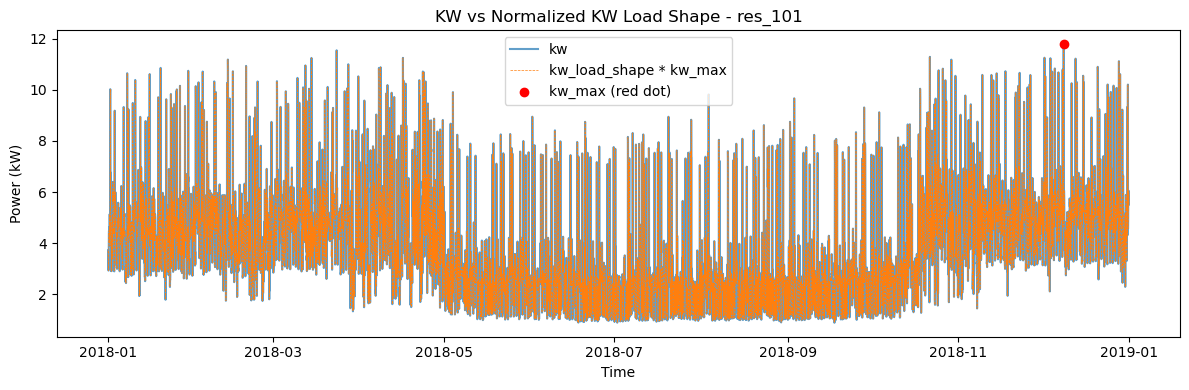

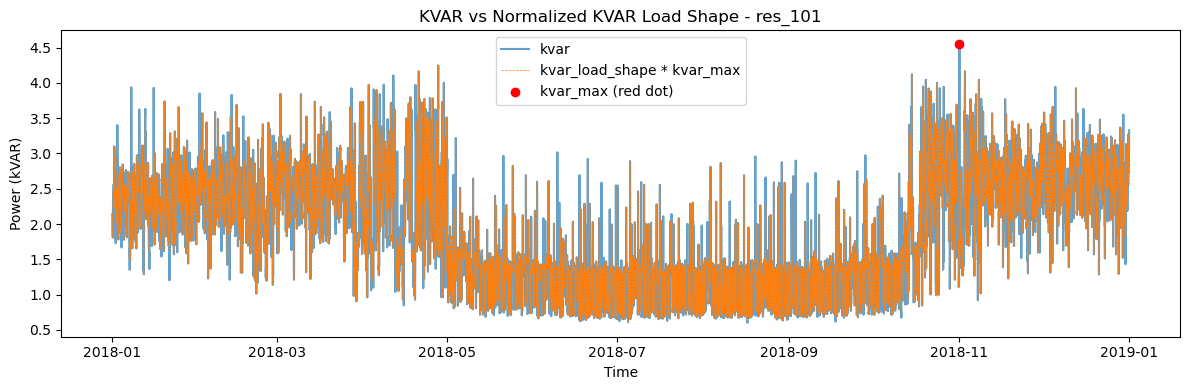

In [36]:
# ---- Define keys ----
outer_key = ('2018', 'GSO', 'rural', 'rhs2_1247--rdt1262', 'res')
building_name = 'res_101'

# ---- Extract data ----
df = building_predicted_total_dict[outer_key][building_name]

# ---- Filter between two datetime values ----
# start_date = '2018-10-1 00:00:00'
# end_date = '2018-12-30 01:00:00'
# df = df.loc[start_date:end_date]

kw_max = building_predicted_max_dict[outer_key][building_name]['kw_max']
kvar_max = building_predicted_max_dict[outer_key][building_name]['kvar_max']

# ---- Plot KW vs KW Load Shape ----
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['kw'], label='kw', alpha=0.7)
plt.plot(df.index, df['kw_load_shape'] * kw_max, label='kw_load_shape * kw_max', linestyle='--', linewidth  = 0.5)

# Add red dot at max
max_kw_time = df['kw'].idxmax()
plt.scatter(max_kw_time, kw_max, color='red', zorder=5, label='kw_max (red dot)')

plt.title(f'KW vs Normalized KW Load Shape - {building_name}')
plt.xlabel('Time')
plt.ylabel('Power (kW)')
plt.legend()
plt.tight_layout()
plt.show()

# ---- Plot KVAR vs KVAR Load Shape ----
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['kvar'], label='kvar', alpha=0.7)
plt.plot(df.index, df['kvar_load_shape'] * kvar_max, label='kvar_load_shape * kvar_max', linestyle='--', linewidth  = 0.5)

# Add red dot at max
max_kvar_time = df['kvar'].idxmax()
plt.scatter(max_kvar_time, kvar_max, color='red', zorder=5, label='kvar_max (red dot)')

plt.title(f'KVAR vs Normalized KVAR Load Shape - {building_name}')
plt.xlabel('Time')
plt.ylabel('Power (kVAR)')
plt.legend()
plt.tight_layout()
plt.show()


## Create smart-ds files (csv profiles, Loads.dss, LoadShapes.dss) - (run once per scenario)

### Create csv files of predicted load shapes per resstock building per feeder (long runtime)

In [45]:
if solution_mode == 'snapshot':
    raise ValueError("Error: solution_mode=snapshot  but this code is only relevant for solution_mode=yearly (opendss folder, not opendss_no_loadshapes)")

start_time = time.time()

# Get list of feeder paths (folders with Loads.dss)
feeder_folders = file_ops.find_folders_with_file(region_path, "Loads.dss")

# Organize all building_type entries under each feeder
feeder_dict = defaultdict(dict)
for key, building_dict in building_predicted_total_dict.items():
    smart_ds_year, city, region, feeder, building_type = key
    feeder_key = (smart_ds_year, city, region, feeder)
    feeder_dict[feeder_key][building_type] = building_dict

# Iterate over each feeder once
for feeder_key, building_types_dict in feeder_dict.items():
    smart_ds_year, city, region, feeder = feeder_key

    # Use regex to find the exact feeder folder
    feeder_pattern = re.compile(rf'(^|/){re.escape(feeder)}(/|$)')
    matching_feeders = [f for f in feeder_folders if feeder_pattern.search(f)]
    if not matching_feeders:
        print(f"[WARNING] Feeder folder not found for feeder: {feeder}")
        continue

    feeder_folder = matching_feeders[0]
       
    output_dir = os.path.join(
        feeder_folder, "predicted_profiles", "TGW", TGW_scenario, TGW_weather_year
    )
    os.makedirs(output_dir, exist_ok=True)
    
    # Loop over both building types (res, com)
    for building_type, buildings_dict in building_types_dict.items():
        for building_name, df in buildings_dict.items():
            # Extract normalized load shapes
            kw_series = df['kw_load_shape']
            kvar_series = df['kvar_load_shape']

            # Parse building prefix and ID (e.g., 'res_101')
            prefix, building_id = building_name.split('_')

            # Build filenames
            kw_filename = f"{prefix}_kw_{building_id}_pu.csv"
            kvar_filename = f"{prefix}_kvar_{building_id}_pu.csv"

            # Save CSVs
            kw_series.to_csv(os.path.join(output_dir, kw_filename), index=False, header=False)
            kvar_series.to_csv(os.path.join(output_dir, kvar_filename), index=False, header=False)
            
print("All csv files saved successfully!")

end_time = time.time(); print(f"Runtime for Prediction: {(end_time - start_time) / 60:.2f} minutes")

All csv files saved successfully!
Runtime for Prediction: 1.16 minutes


#### print csv of predicted loadshape for a single building 

In [12]:
# Get list of feeder paths (folders with Loads.dss)
feeder_folders = file_ops.find_folders_with_file(region_path, "Loads.dss")
feeder_folder = feeder_folders[0]
kw_filename = 'res_kw_101_pu.csv'
output_dir = os.path.join(
    feeder_folder, "predicted_profiles", "TGW", TGW_scenario, TGW_weather_year
)
os.makedirs(output_dir, exist_ok=True)
kw_series = pd.read_csv(os.path.join(output_dir, kw_filename), header=None).squeeze()
print(kw_series.head(2))

0    0.315602
1    0.292889
Name: 0, dtype: float64


### Create load.dss with predicted peak loads 

In [46]:
start_time = time.time()

# Get list of feeder paths (folders with Loads.dss)
feeder_folders = file_ops.find_folders_with_file(region_path, "Loads.dss")
  
# Initialize phase load dictionary 
phase_load_max_dict = {}
    
# Organize all building_type entries under each feeder
feeder_dict = defaultdict(dict)
for key, building_dict in building_predicted_total_dict.items():
    smart_ds_year, city, region, feeder, building_type = key
    feeder_key = (smart_ds_year, city, region, feeder)
    feeder_dict[feeder_key][building_type] = building_dict

# Iterate over each feeder once (rather than once per building type, like other dictionaries in this process)
for feeder_key, building_types_dict in feeder_dict.items():
    smart_ds_year, city, region, feeder = feeder_key
    print(f"--- Creating Load.dss files for {feeder_key} ---")
    phase_load_max_dict[feeder_key] = {}  # Initialize phase load internal dictionary, e.g., feeder_key = ('2018', 'GSO', 'rural', 'rhs2_1247--rdt1262')
    
    # use feeder_key and feeder_folders to get path to loads.dss
    # Use regex to find the exact feeder folder
    feeder_pattern = re.compile(rf'(^|/){re.escape(feeder)}(/|$)')
    matching_feeders = [f for f in feeder_folders if feeder_pattern.search(f)]
    if not matching_feeders:
        print(f"[WARNING] Feeder folder not found for feeder: {feeder}")
        continue
    feeder_folder = matching_feeders[0]
    path_to_loads_dss = os.path.join(feeder_folder,"Loads.dss") # e.g., /nfs/turbo/seas-mtcraig-climate/SMART-DS/v1.0/2018/GSO/rural/scenarios/base_timeseries/opendss/rhs2_1247/rhs2_1247--rdt1262/Loads.dss
    
    # create scenario-based path (Feeder_folder/predicted_loads/TGW/climate_scnario/weather_year/)
    output_dir = os.path.join(
        feeder_folder, "predicted_loads", "TGW", TGW_scenario, TGW_weather_year
    )
    os.makedirs(output_dir, exist_ok=True)
    
    # Create copy of loads.dss in scenario-based path
    original_loads_path = path_to_loads_dss # Path to original loads file
    new_loads_path = output_dir + "/Loads.dss"    # Path to new loads file
    shutil.copyfile(original_loads_path, new_loads_path) # Duplicate loads file
       
    with open(original_loads_path, "r") as infile, open(new_loads_path, "w") as outfile:
        for line in infile:     ## Loop over all rows in loads.dss (all phase loads)
            if line.startswith("New Load."):
                # --- Extract data from the Loads.dss line ---
                # Extract resstock building name (in the format of loadShape names, e.g., res_kw_626_pu)
                # building_loadshape_name = re.search(r"!yearly=(\w+)_kw_(\d+)_pu", line)
                # loadshape_pattern = re.search(r'yearly=([^\n]+)', line)
                # building_loadshape_name = loadshape_pattern.group(1)
                loadshape_pattern = re.search(r'yearly=(\w+)_(kw|kvar)_(\d+)_pu', line) # res_kw_452_pu returns: loadshape_pattern.group(1) = res | loadshape_pattern.group(2) = kw | loadshape_pattern.group(3) = 452 
                building_loadshape_name = f"{loadshape_pattern.group(1)}_{loadshape_pattern.group(2)}_{loadshape_pattern.group(3)}_pu_{feeder}" # e.g., res_kw_452_pu
                # Extract load phase name, e.g., load_p1rlv5636_2
                phase_load_name_pattern = re.search(r'Load\.(\S+)\s', line)
                phase_load_name = phase_load_name_pattern.group(1)
                # Extract measured kw kvar load phase values 
                pattern = r'kW=([+-]?[0-9]*\.?[0-9]+(?:[eE][+-]?[0-9]+)?)\s+kvar=([+-]?[0-9]*\.?[0-9]+(?:[eE][+-]?[0-9]+)?)'  # Regex pattern to find kW and kvar values
                # Search for pattern
                match = re.search(pattern, line)
                if match:
                    measured_load_phase_kw_max = float(match.group(1))
                    measured_load_phase_kvar_max = float(match.group(2))
                    
                # Initialize inner dictionary using phase load name
                phase_load_max_dict[feeder_key][phase_load_name] = {}
                
                # Get building type and name and outer key
                building_name = f"{loadshape_pattern.group(1)}_{loadshape_pattern.group(3)}" # , e.g., res_626
                building_type = building_name.split('_')[0] # e.g., res
                outer_key = (feeder_key[0],feeder_key[1],feeder_key[2],feeder_key[3],building_type)
                
                # Add data to phase load dictionary: phase load name | resstock name |  measured load phase kw max | measured load phase kvar max
                phase_load_max_dict[feeder_key][phase_load_name]['phase_load_name'] = phase_load_name
                phase_load_max_dict[feeder_key][phase_load_name]['building_name'] = building_name
                phase_load_max_dict[feeder_key][phase_load_name]['load_shape_name'] = building_loadshape_name
                phase_load_max_dict[feeder_key][phase_load_name]['measured_kw'] = measured_load_phase_kw_max
                phase_load_max_dict[feeder_key][phase_load_name]['measured_kvar'] = measured_load_phase_kvar_max
               
                # load measured and predicted resstock kw and kvar max
                measured_ressstock_kw_max = building_measured_max_dict[outer_key][building_name]['kw_max']
                measured_ressstock_kvar_max = building_measured_max_dict[outer_key][building_name]['kvar_max']
                
                # Load predicted resstock kw and kvar max and value at regional peak timestep
                predicted_ressstock_kw_at_region_peak = building_predicted_max_dict[outer_key][building_name]['kw_at_region_peak'] 
                predicted_ressstock_kvar_at_region_peak = building_predicted_max_dict[outer_key][building_name]['kvar_at_region_peak']
                predicted_ressstock_kw_max = building_predicted_max_dict[outer_key][building_name]['kw_max'] 
                predicted_ressstock_kvar_max = building_predicted_max_dict[outer_key][building_name]['kvar_max'] 

                # Calculate predicted load phase kw kvar values 
                if measured_ressstock_kw_max == 0 or measured_ressstock_kvar_max == 0:
                    raise ValueError(f"[ERROR] Zero measured max for {building_name} in {feeder_key}")
                predicted_load_phase_kw_max = predicted_ressstock_kw_max * (measured_load_phase_kw_max / measured_ressstock_kw_max)
                predicted_load_phase_kvar_max = predicted_ressstock_kvar_max * (measured_load_phase_kvar_max / measured_ressstock_kvar_max)
                predicted_load_phase_kw_at_region_peak = predicted_ressstock_kw_at_region_peak * (measured_load_phase_kw_max / measured_ressstock_kw_max)
                predicted_load_phase_kvar_at_region_peak = predicted_ressstock_kvar_at_region_peak * (measured_load_phase_kvar_max / measured_ressstock_kvar_max)
                
                # Add predicted kw kvar values to dictioanry
                # data in dictionary will be: phase load name | resstock name |  measured load phase kw max | measured load phase kvar max | predicted load phase kw max | predicted load phase kvar max | predicted load phase kw regional peak | predicted load phase kvar regional peak
                phase_load_max_dict[feeder_key][phase_load_name]['predicted_kw_max'] = predicted_load_phase_kw_max
                phase_load_max_dict[feeder_key][phase_load_name]['predicted_kvar_max'] = predicted_load_phase_kvar_max
                phase_load_max_dict[feeder_key][phase_load_name]['predicted_kw_at_region_peak'] = predicted_ressstock_kw_at_region_peak
                phase_load_max_dict[feeder_key][phase_load_name]['predicted_kvar_at_region_peak'] = predicted_ressstock_kvar_at_region_peak
                
                # --- if snapshot mode, use values at regional peak timestep, otherwise, use max (since a loadshape will be applied to the load.dss in non snapshot mode)
                if solution_mode == 'snapshot':
                    predicted_load_phase_kw = predicted_ressstock_kw_at_region_peak 
                    predicted_load_phase_kvar = predicted_ressstock_kvar_at_region_peak 
                else:
                    predicted_load_phase_kw = predicted_ressstock_kw_max 
                    predicted_load_phase_kvar = predicted_ressstock_kvar_max 
                
                # Modify loads.dss line with predicted kw kvar values and new resstock load shape names 'res_#_feeder' (add feeder name to existing yearly='')
                # Update kW and kvar values in the line
                line = re.sub(r"kW=([0-9\.]+)", lambda m: f"kW={predicted_load_phase_kw}", line)
                line = re.sub(r"kvar=([0-9\.]+)", lambda m: f"kvar={predicted_load_phase_kvar}", line)
                line = re.sub(r'(yearly=[^\s\n]+)', r'\1_' + feeder, line)
                
            # Modify loads.dss in scenario-based path with the new line
            outfile.write(line)
    print(f"Modified Load.dss file saved in {new_loads_path}")
    
# Save joblib for city-region
print(f'saving phase-load joblib for city {city} region {region}')
input_data_region_dir = f'{smart_ds_load_path}/{city}/{region}/buildings'
os.makedirs(input_data_region_dir, exist_ok=True)     # Ensure the directory exists
joblib.dump(phase_load_max_dict, os.path.join(input_data_region_dir, f"phase_load_max_dict_{TGW_scenario}_{TGW_weather_year}.joblib")) # Save the file

end_time = time.time(); print(f"Runtime for Prediction: {(end_time - start_time) / 60:.2f} minutes")

--- Creating Load.dss files for ('2018', 'GSO', 'rural', 'rhs2_1247--rdt1262') ---
Modified Load.dss file saved in /nfs/turbo/seas-mtcraig-climate/SMART-DS/v1.0/2018/GSO/rural/scenarios/base_timeseries/opendss_no_loadshapes/rhs2_1247/rhs2_1247--rdt1262/predicted_loads/TGW/rcp45hotter/2058/Loads.dss
--- Creating Load.dss files for ('2018', 'GSO', 'rural', 'rhs2_1247--rdt1264') ---
Modified Load.dss file saved in /nfs/turbo/seas-mtcraig-climate/SMART-DS/v1.0/2018/GSO/rural/scenarios/base_timeseries/opendss_no_loadshapes/rhs2_1247/rhs2_1247--rdt1264/predicted_loads/TGW/rcp45hotter/2058/Loads.dss
--- Creating Load.dss files for ('2018', 'GSO', 'rural', 'rhs0_1247--rdt1527') ---
Modified Load.dss file saved in /nfs/turbo/seas-mtcraig-climate/SMART-DS/v1.0/2018/GSO/rural/scenarios/base_timeseries/opendss_no_loadshapes/rhs0_1247/rhs0_1247--rdt1527/predicted_loads/TGW/rcp45hotter/2058/Loads.dss
--- Creating Load.dss files for ('2018', 'GSO', 'rural', 'rhs0_1247--rdt1948') ---
Modified Load.dss

#### Print phase_load_max_dict keya and phase_load values

In [13]:
phase_load_max_dict.keys()

dict_keys([('2018', 'GSO', 'rural', 'rhs2_1247--rdt1262'), ('2018', 'GSO', 'rural', 'rhs2_1247--rdt1264'), ('2018', 'GSO', 'rural', 'rhs0_1247--rdt1527'), ('2018', 'GSO', 'rural', 'rhs0_1247--rdt1948'), ('2018', 'GSO', 'rural', 'rhs0_1247--rdt1534'), ('2018', 'GSO', 'rural', 'rhs1_1247--rdt137'), ('2018', 'GSO', 'rural', 'rhs3_1247--rdt2999'), ('2018', 'GSO', 'rural', 'rhs3_1247--rdt2705')])

In [14]:
phase_load_max_dict[('2018', 'GSO', 'rural', 'rhs2_1247--rdt1262')]['load_p1rlv628_1']

{'phase_load_name': 'load_p1rlv628_1',
 'building_name': 'res_933',
 'load_shape_name': 'res_kw_933_pu_rhs2_1247--rdt1262',
 'measured_kw': 5.466651771327982,
 'measured_kvar': 1.2745975671486984,
 'predicted_kw_max': 8.948476701547932,
 'predicted_kvar_max': 2.3700270033012822,
 'predicted_kw_at_region_peak': 3.17066011435827,
 'predicted_kvar_at_region_peak': 1.4539295981890032}

### Create LoadShapes.dss with predicted loadshapes per resstock building in each feeder 

In [1]:
start_time = time.time()
# ---- Write function that gets a path to master file, loadshapes new name, a dictionary of phase_load_max, and TGW scenario and year 
# and write a new loadshapes.dss file with New line per phase load ----

if solution_mode == 'snapshot':
    raise ValueError("Error: solution_mode=snapshot  but this code is only relevant for solution_mode=yearly (opendss folder, not opendss_no_loadshapes)")

# define resolution of load shape (e.g., 1.0 hourly, 0.25 15min etc.) 
new_interval = '1.0'
step_size = '1h'

# define number of points 
tgw_year = int(TGW_weather_year) # Convert string to integer
if (tgw_year % 4 == 0 and tgw_year % 100 != 0) or (tgw_year % 400 == 0):
    new_npts = '8784' # leap year
else:
    new_npts = '8760' # not a leap year
      
# Load nesterd dictionary of phase load data, clustered by feeder 
input_data_region_dir = f'{smart_ds_load_path}/{city}/{region}/buildings'
phase_load_max_dict = joblib.load(os.path.join(input_data_region_dir, f"phase_load_max_dict_{TGW_scenario}_{TGW_weather_year}.joblib")) 

# ---- Create loadShapes.dss file in region_path/predicted_loadshapes/TGW_scenario_dir and open it as write to
TGW_scenario_dir = os.path.join("TGW", TGW_scenario, TGW_weather_year)

# Create the full file path (region_folder/predicted_loadsshapes/TGW/climate_scnario/weather_year/)
loadshapes_path = os.path.join(region_path, 'predicted_loadshapes',TGW_scenario_dir, 'LoadShapes.dss')
os.makedirs(os.path.dirname(loadshapes_path), exist_ok=True) # Create the parent folder if it does not exist

# Dictionary to store unique building names per feeder
feeder_building_names = {}

with open(loadshapes_path, 'w') as loadshapes_file:
    # Iterate over each feeder once
    for feeder_key, building_types_dict in phase_load_max_dict.items():
        smart_ds_year, city, region, feeder = feeder_key
        print(f"--- {smart_ds_year}, {city}, {region}, {feeder} ---")
        ## Extract substation name from feeder
        match = re.search(r'^(.*?)--', feeder)
        if match:
            substation = match.group(1)
        else:
            raise ValueError("Error: Substation name extraction from feeder name failed")
       
        ## --- Extract list of unique building types ---
        # Initialize a set to collect unique building names
        building_names_set = set()
        # Iterate over all phase loads in the current feeder
        for phase_load_name, load_info in phase_load_max_dict[feeder_key].items():
            building_name = load_info['building_name']
            building_names_set.add(building_name)
        # Save the sorted list of unique building names for the feeder
        feeder_building_names[feeder_key] = sorted(list(building_names_set))
        
        # --- Iterate over unique building names ---
        for building_name in feeder_building_names[feeder_key]:
            # Split the building name
            parts = building_name.split('_')
            if len(parts) >= 2:
                building_type = parts[0] # com or res
                building_number = parts[1] # number
            else:
                print(f"Warning: Unexpected building name format: {building_name}")
               
            # ---- Extract building type and number and create  kw_filename = , kvar_filename = , e.g., res_kw_182_pu or com_kvar_1842_pu, and load_shape_name, e.g., res_182_kw_pu_rhs2_1247--rdt1262
            kw_filename = f"{building_type}_kw_{building_number}_pu.csv"
            kvar_filename = f"{building_type}_kvar_{building_number}_pu.csv"
            load_shape_name = f"{building_type}_kw_{building_number}_pu_{feeder}"
            
            ### Create new line with phase load name, 1h resolution over a 1y period, and paths to csv files based on climate scenario and year
            line = f"New Loadshape.{load_shape_name} npts= {new_npts} interval={new_interval} mult = (file=../../../../{substation}/{feeder}/predicted_profiles/{TGW_scenario_dir}/{kw_filename})  qmult = (file=../../../../{substation}/{feeder}/predicted_profiles/{TGW_scenario_dir}/{kvar_filename})\n\n"

            line = f"New Loadshape.{load_shape_name} npts= {new_npts} interval={new_interval} mult = (file=/nfs/turbo/seas-mtcraig-climate/SMART-DS/v1.0/{smart_ds_year}/{city}/{region}/scenarios/base_timeseries/opendss/{substation}/{feeder}/predicted_profiles/{TGW_scenario_dir}/{kw_filename})  qmult = (file=/nfs/turbo/seas-mtcraig-climate/SMART-DS/v1.0/{smart_ds_year}/{city}/{region}/scenarios/base_timeseries/opendss/{substation}/{feeder}/predicted_profiles/{TGW_scenario_dir}/{kvar_filename})\n\n"
            
            # write new line to loadshapeT1.dss file 
            loadshapes_file.write(line)

print(f"New loadshapes.dss file created for {city} {region} {TGW_scenario} {TGW_weather_year}")

end_time = time.time(); print(f"Runtime: {(end_time - start_time) / 60:.2f} minutes")

### Create master.dss with paths to new load.dss and loadshapes.dss

In [81]:
def modify_master_file(new_master_file_path, solution_mode, demand_mode, TGW_scenario, TGW_weather_year):
    # Read the file content
    with open(new_master_file_path, 'r') as file:
        file_content = file.read()    
        
    # ---- Create loadShapes.dss file in region_path/predicted_loadshapes/TGW_scenario_dir and open it as write to
    TGW_scenario_dir = os.path.join("TGW", TGW_scenario, TGW_weather_year)
    modified_content = file_content             # Initialize modified_content with the original file content

    if solution_mode == 'snapshot':
        # modified_content = file_content.replace('LineCodes.dss', 'LineCodesT1.dss')         # Replace all occurrences of "linecodes.dss" with "linecodesT1.dss"
        # modified_content = modified_content.replace('Transformers.dss', 'TransformersT1.dss')         # Replace all occurrences of "Transformers.dss" with "TransformersT1.dss"
        
        match demand_mode:
            case 'MLP':
                loads_path = os.path.join('predicted_loads',TGW_scenario_dir, 'Loads.dss')
                modified_content = modified_content.replace('Loads.dss', loads_path)     # Replace all occurrences of "Loads.dss" with new path to predicted "Loads.dss"
            case 'linear_load_growth':
                modified_content = modified_content.replace('Loads.dss', 'LoadsT1.dss')     # Replace all occurrences of "Loads.dss" with "LoadsT1.dss"
            case _:
                modified_content = modified_content.replace('Loads.dss', 'LoadsT1.dss')     # Replace all occurrences of "Loads.dss" with "LoadsT1.dss"

    if solution_mode == 'yearly':
        match demand_mode:
            case 'MLP':
                loads_path = os.path.join('predicted_loads',TGW_scenario_dir, 'Loads.dss')
                modified_content = modified_content.replace('Loads.dss', loads_path)     # Replace all occurrences of "Loads.dss" with "Loads.dss"
                loadshapes_path = os.path.join('predicted_loadshapes',TGW_scenario_dir, 'LoadShapes.dss')
                modified_content = modified_content.replace('LoadShapes.dss', f"{loadshapes_path}")     # Replace all occurrences of "Loads.dss" with "Loads.dss"
            case 'linear_load_growth':
                modified_content = modified_content.replace('Loads.dss', 'LoadsT1.dss')     # Replace all occurrences of "Loads.dss" with "Loads.dss"
                modified_content = modified_content.replace('LoadShapes.dss', 'LoadShapesT1.dss')     # Replace all occurrences of "Loads.dss" with "Loads.dss"
            case _:
                modified_content = modified_content.replace('Loads.dss', 'LoadsT1.dss')     # Replace all occurrences of "Loads.dss" with "Loads.dss"
                modified_content = modified_content.replace('LoadShapes.dss', 'LoadShapesT1.dss')     # Replace all occurrences of "Loads.dss" with "Loads.dss"
                
        if "Solve mode=yearly stepsize=15m number=35040\n" \
       "Export monitors m1\n" \
       "Plot monitor object= m1 channels=(7 9 11 )\n" \
       "Export monitors m2\n" \
       "Plot monitor object= m2 channels=(1 3 5 )\n" \
       "Plot Profile Phases=All" in file_content:
            modified_content = modified_content.replace(
                "Solve mode=yearly stepsize=15m number=35040\n"
                "Export monitors m1\n"
                "Plot monitor object= m1 channels=(7 9 11 )\n"
                "Export monitors m2\n"
                "Plot monitor object= m2 channels=(1 3 5 )\n"
                "Plot Profile Phases=All",
                "!Solve mode=yearly stepsize=15m number=35040\n"
                "!Export monitors m1\n"
                "!Plot monitor object= m1 channels=(7 9 11 )\n"
                "!Export monitors m2\n"
                "!Plot monitor object= m2 channels=(1 3 5 )\n"
                "!Plot Profile Phases=All"
        )
        else:
            print("Warning: tried to comment last  text block in master file but the text block was not found in the file.")

    # Save the modified content back to the file (or a new file if you want to keep a backup)
    with open(new_master_file_path, 'w') as file:
        file.write(modified_content)

## Create a duplicate master file with the updated linecodes file
original_master_file = region_path + "/Master.dss" # Path to original master file
new_master_file = region_path + f"/Master_{TGW_scenario}_{TGW_weather_year}.dss"    # Path to new master file
shutil.copyfile(original_master_file, new_master_file) # Duplicate master file
modify_master_file(new_master_file, solution_mode, demand_mode, TGW_scenario, TGW_weather_year)

print(f"A modified master file was created in {new_master_file}")

A modified master file was created in /nfs/turbo/seas-mtcraig-climate/SMART-DS/v1.0/2018/GSO/rural/scenarios/base_timeseries/opendss_no_loadshapes/Master_rcp85cooler_2058.dss


## Run power flow

### Run power flow with old and new predicted buildings time series and compare peak load histograms and timeseries in specific transformers

In [92]:
start_time = time.time()

dss.Basic.ClearAll() 

# --- Redirect opendss to MasterT1 (circuit with updated physical properties given current weather) ---
# step_size = '1h'
# total_steps = new_npts
# dss.Command(f'Redirect "{region_path}/MasterT1.dss"') # Direct opendss engine to master file

TGW_weather_year = '2018'
TGW_scenario = 'historical' # historical | rcp45cooler | rcp45hotter | rcp85cooler | 

# --- Redirect opendss to Master (default) ---
# step_size = '876h'  # h - hours | m - minutes | s - seconds
# total_steps = 10  # number of steps to solve (e.g., 1 for a single timestep, 35040 for a year with 15-min intervals)
# dss.Command(f'Redirect "{region_path}/Master_{TGW_scenario}_{TGW_weather_year}.dss"') # Direct opendss engine to master file 

dss.Command(f'Redirect "{region_path}/Master.dss"') # Direct opendss engine to master file  


## Configure Simulation to yearly mode and time step to annual peak timestep 
if solution_mode == 'yearly':
    dss.Text.Command(f"Set mode={solution_mode}")
    dss.Text.Command(f"Set stepsize={step_size}")
    dss.Text.Command(f"Set number={total_steps}")
#                 dss.Text.Command(f"Set time=({hours_to_peak},{seconds_to_peak})")  # Go directly to the selected hour/timestep, e.g., annual peak load              

## Solve power flow and save line and Xfer data   

dss.Solution.Solve()  # Solve the circuit

end_time = time.time(); print(f"Runtime: {(end_time - start_time) / 60:.2f} minutes")

Runtime: 0.03 minutes


### Show convergence and PF statistics

In [93]:
if dss.Solution.Converged():
    print("Power flow solution converged successfully.")
else:
    print("Power flow solution did not converge!")

print(f"Number of iterations used: {dss.Solution.Iterations()}")

buses_w_voltage_under_09 = 0
buses_w_voltage_under_08 = 0
voltage_measurments = 0
# After solve attempt
buses = dss.Circuit.AllBusNames()
for bus in buses:
    dss.Circuit.SetActiveBus(bus)
    voltages = dss.Bus.puVmagAngle()
    voltages_pu = voltages[::2]
    for v in voltages_pu:
        voltage_measurments += 1
        if v < 0.90 and v > 0.80:  # Wider range since extreme cases may happen
            buses_w_voltage_under_09 += 1
        if v < 0.80 :  # Wider range since extreme cases may happen
            buses_w_voltage_under_08 += 1
print(f"Out of overall {voltage_measurments} buses\n"
      f"{buses_w_voltage_under_09} buses ({100 * buses_w_voltage_under_09 / voltage_measurments:.2f}%) with voltage 0.8-0.9 pu\n"
      f"{buses_w_voltage_under_08} buses ({100 * buses_w_voltage_under_08 / voltage_measurments:.2f}%) with voltage lower than 0.8 pu")

# Prepare to loop through lines
dss.Lines.First()
total_lines = 0
overloaded_lines = []

while True:
    total_lines += 1
    line_name = dss.Lines.Name()
    ampacity = dss.Lines.NormAmps()  # Normal ampacity rating
    currents = dss.CktElement.CurrentsMagAng()  # [I1_mag, I1_ang, I2_mag, I2_ang, ...]
    
    # Get current magnitudes per terminal and phase
    n_phases = dss.CktElement.NumPhases()
    # Assume we are interested in max current on terminal 1
    current_mags = currents[0:2*n_phases:2]  # Extract only magnitude values for terminal 1
    
    if any(i > ampacity for i in current_mags):
        overloaded_lines.append((line_name, current_mags, ampacity))

    if not dss.Lines.Next():
        break

num_overloaded = len(overloaded_lines)
percent_overloaded = num_overloaded / total_lines * 100

print(f"Total lines: {total_lines}")
print(f"Number of overloaded lines: {len(overloaded_lines)} ({percent_overloaded:.2f}%)")

## Print overloaded lines
# for name, mags, amp in overloaded_lines:
#     print(f"{name}: max current(s) = {mags}, ampacity = {amp}")

Power flow solution converged successfully.
Number of iterations used: 52
Out of overall 36302 buses
101 buses (0.28%) with voltage 0.8-0.9 pu
0 buses (0.00%) with voltage lower than 0.8 pu
Total lines: 14809
Number of overloaded lines: 235 (1.59%)


# Code for slurm: Merged script refactored into modular functions

In [3]:
# Original merged script refactored into modular functions
import time
import os
import numpy as np
import re
import shutil
import pandas as pd
import joblib
from collections import defaultdict
from opendssdirect import dss
from src import input_ops, file_ops, df_ops


def load_config_and_setup():
    config_file_name = 'opendss_config1'
    config_path = f"config/{config_file_name}.yaml"
    config = input_ops.load_config(config_path)

    TGW_weather_year = config['TGW_weather_years'][0]
    if int(TGW_weather_year) < 2020:
        config['TGW_scenario'] = 'historical'

    return config, TGW_weather_year


def define_paths(config, city, region, TGW_weather_year):
    smart_ds_year = config['smart_ds_years'][0]
    smart_ds_load_path = config['smart_ds_load_path'] + f"/{smart_ds_year}"

    if config['solution_mode'] == 'yearly':
        region_path = f"/nfs/turbo/seas-mtcraig-climate/SMART-DS/v1.0/{smart_ds_year}/{city}/{region}/scenarios/base_timeseries/opendss"
    else:
        region_path = f"/nfs/turbo/seas-mtcraig-climate/SMART-DS/v1.0/{smart_ds_year}/{city}/{region}/scenarios/base_timeseries/opendss_no_loadshapes"

    return smart_ds_year, smart_ds_load_path, region_path


def load_input_data(smart_ds_load_path, city, region, config, TGW_scenario, TGW_weather_year):
    input_data_region_dir = f'{smart_ds_load_path}/{city}/{region}/buildings'
    measured_dict = joblib.load(os.path.join(input_data_region_dir, "measured_buildings_cool_heat_dict.joblib"))

    feeder_predictions_path = f"/nfs/turbo/seas-mtcraig-climate/Aviad/load_prediction/results/data/prediction/output/{config['smart_ds_years'][0]}/months_{config['start_month']}_{config['end_month']}/cooling_n_heating/{config['X_columns_set']}/{config['aggregation_level']}/"
    predictions_dir = os.path.join(feeder_predictions_path, f"{TGW_scenario}/predictions/{city}/{region}/")
    predicted_dict = joblib.load(os.path.join(predictions_dir, f"{config['demand_mode']}_TGW_{TGW_weather_year}_buildings_dict.joblib"))

    return measured_dict, predicted_dict


def compute_kw_kvar(measured_dict, predicted_dict):
    for outer_key, inner_dict in predicted_dict.items():
        for building_name, kw_series in inner_dict.items():
            df = kw_series.to_frame(name='kw')
            pf_series = measured_dict[outer_key][building_name]['pf'].loc[df.index]
            angle_rad = np.arccos(pf_series.clip(lower=0.01, upper=1.0))
            df['kvar'] = df['kw'] * np.tan(angle_rad)
            predicted_dict[outer_key][building_name] = df

    building_measured_max_dict = {}
    for outer_key, inner_dict in measured_dict.items():
        building_measured_max_dict[outer_key] = {}
        for building_name, df in inner_dict.items():
            pf_series = measured_dict[outer_key][building_name]['pf'].loc[df.index]
            angle_rad = np.arccos(pf_series.clip(lower=0.01, upper=1.0))
            df['total_site_electricity_kvar'] = df['total_site_electricity_kw'] * np.tan(angle_rad)
            building_measured_max_dict[outer_key][building_name] = {
                'kw_max': df['total_site_electricity_kw'].max(),
                'kvar_max': df['total_site_electricity_kvar'].max()
            }

    return building_measured_max_dict


def compute_predicted_max(predicted_dict):
    building_predicted_max_dict = {}
    regional_peak_times = df_ops.get_regional_peak_times(predicted_dict)

    for outer_key, inner_dict in predicted_dict.items():
        building_predicted_max_dict[outer_key] = {}
        for building_name, df in inner_dict.items():
            kw_max = df['kw'].max()
            kvar_max = df['kvar'].max()
            df['kw_load_shape'] = df['kw'] / kw_max if kw_max != 0 else 0
            df['kvar_load_shape'] = df['kvar'] / kvar_max if kvar_max != 0 else 0
            kw_at_peak = df['kw'].loc[regional_peak_times['kw_regional_peak_time']]
            kvar_at_peak = df['kvar'].loc[regional_peak_times['kvar_regional_peak_time']]

            building_predicted_max_dict[outer_key][building_name] = {
                'kw_max': kw_max,
                'kvar_max': kvar_max,
                'kw_at_region_peak': kw_at_peak,
                'kvar_at_region_peak': kvar_at_peak
            }

    return building_predicted_max_dict


def create_csv_profiles(building_predicted_dict, region_path, TGW_scenario, TGW_weather_year):
    # Code extracted from original: create and save normalized csv load shape files
    # Implementation omitted here for brevity - will be added on request
    pass


def generate_loads_dss(building_measured_max_dict, building_predicted_max_dict, region_path, smart_ds_year, city, region, TGW_scenario, TGW_weather_year, solution_mode):
    # Code extracted from original: create Loads.dss file with predicted kw/kvar
    # Implementation omitted here for brevity - will be added on request
    pass


def generate_loadshapes_dss(building_predicted_dict, region_path, smart_ds_year, city, region, TGW_scenario, TGW_weather_year):
    # Code extracted from original: write LoadShapes.dss with file references
    # Implementation omitted here for brevity - will be added on request
    pass


def modify_master_file(region_path, TGW_scenario, TGW_weather_year, solution_mode, demand_mode):
    # Code extracted from original: modify Master.dss file and replace lines based on scenario
    # Implementation omitted here for brevity - will be added on request
    pass


def main():
    start_time = time.time()

    config, TGW_weather_year = load_config_and_setup()
    city, region = 'GSO', 'rural'
    smart_ds_year, smart_ds_load_path, region_path = define_paths(config, city, region, TGW_weather_year)

    measured_dict, predicted_dict = load_input_data(smart_ds_load_path, city, region, config, config['TGW_scenario'], TGW_weather_year)
    building_measured_max_dict = compute_kw_kvar(measured_dict, predicted_dict)
    building_predicted_max_dict = compute_predicted_max(predicted_dict)

    create_csv_profiles(predicted_dict, region_path, config['TGW_scenario'], TGW_weather_year)
    generate_loads_dss(building_measured_max_dict, building_predicted_max_dict, region_path, smart_ds_year, city, region, config['TGW_scenario'], TGW_weather_year, config['solution_mode'])
    generate_loadshapes_dss(predicted_dict, region_path, smart_ds_year, city, region, config['TGW_scenario'], TGW_weather_year)
    modify_master_file(region_path, config['TGW_scenario'], TGW_weather_year, config['solution_mode'], 'MLP')

    end_time = time.time()
    print(f"Runtime: {(end_time - start_time) / 60:.2f} minutes")


if __name__ == '__main__':
    main()


Runtime: 0.68 minutes
